In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from IPython.display import display
from scipy import stats
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import time

In [2]:
# Please manually download bank-additional-full.csv from below link and copy it to the directory of your jupyter notebook:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

# Reading the input file "bank-additional-full"
input_data=pd.read_csv('bank-additional-full.csv')

In [3]:
# See how data looks like
input_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Defining att_val_count function to print the values/counts of input features:
def att_val_count(att_list):
    for i in att_list:
        print("\n"+i)
        print(input_data[i].value_counts())

In [5]:
# Converting "contact", "month", "day_of_week" from categorical to numerical using lable encoding
input_data['contact'] = input_data['contact'].map({'telephone':0, 'cellular':1})
input_data['month'] = input_data['month'].map({'mar':0, 'apr':1,'may':2,'jun':3,'jul':4,'aug':5,'sep':6,'oct':7,'nov':8,'dec':9})
input_data['day_of_week'] = input_data['day_of_week'].map({'mon':0, 'tue':1, 'wed':2,'thu':3,'fri':4})

In [6]:
# cheking the new values for "contact", "month", "day_of_week" after lable encoding
att_val_count({"contact","month","day_of_week"})


month
2    13769
4     7174
5     6178
3     5318
8     4101
1     2632
7      718
6      570
0      546
9      182
Name: month, dtype: int64

day_of_week
3    8623
0    8514
2    8134
1    8090
4    7827
Name: day_of_week, dtype: int64

contact
1    26144
0    15044
Name: contact, dtype: int64


In [7]:
# converting the rest of categorical attributes (such as jub and marital for which order has no meaning) to dummy variables
input_data = pd.get_dummies(data=input_data, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome'])

In [8]:
# Plotting the correlation matrix between features
f = plt.figure(figsize=(19, 15))
corr = input_data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,age,contact,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
age,1.000000,-0.007021,0.077265,-0.018486,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,-0.102584,-0.024191,0.031213,0.085403,0.062040,0.440772,-0.001356,-0.065731,-0.199749,-0.064383,-0.004426,0.047773,0.166125,0.271266,-0.411703,0.001062,0.244079,0.009897,-0.038320,-0.106550,0.017007,0.002054,-0.071138,0.069485,-0.165019,0.165001,0.001891,0.001755,-0.001092,-0.001414,0.007224,-0.001092,-0.007198,-0.002537,-0.016376,0.035626
contact,-0.007021,1.000000,0.324315,-0.019583,0.026657,-0.077368,-0.117970,0.212848,-0.393584,-0.591474,-0.251614,-0.399773,-0.269155,0.059227,-0.094712,-0.018894,-0.010455,0.009031,0.035096,-0.002480,-0.035596,0.040422,0.048635,-0.007691,-0.023454,-0.003111,-0.063648,0.071159,0.002543,-0.050234,-0.045717,-0.054866,-0.013354,0.008624,0.022695,0.103159,-0.020543,0.135451,-0.135604,0.006474,-0.077937,-0.022189,0.084472,-0.003669,-0.022189,0.013367,0.207659,-0.242512,0.111934
month,0.077265,0.324315,1.000000,-0.006959,-0.019302,-0.030635,-0.079556,0.063754,0.058874,-0.150350,0.264227,0.163411,0.132697,0.048007,-0.137050,0.017709,0.015749,0.052320,0.042128,0.017154,-0.061668,-0.000735,0.053849,0.030829,-0.009288,0.009672,0.010255,-0.017394,-0.005574,-0.033916,-0.054866,-0.076971,-0.036751,0.006863,0.032650,0.125366,-0.013355,0.084580,-0.084801,0.010003,-0.029715,-0.011869,0.033252,0.006375,-0.011869,-0.001696,0.007359,-0.043635,0.070997
day_of_week,-0.018486,-0.019583,-0.006959,1.000000,0.010549,0.015098,0.006765,0.004013,-0.004401,-0.004586,-0.000099,-0.005552,-0.000734,0.005294,0.007334,-0.001329,-0.011988,-0.010201,-0.004719,0.004525,-0.003029,0.001535,0.001473,0.006405,-0.015100,-0.012428,-0.001971,0.010839,0.000247,-0.008989,0.005162,0.006534,-0.007824,0.006063,0.000622,-0.000021,0.010917,0.004164,-0.004040,-0.005923,0.008510,0.002607,-0.009280,-0.002793,0.002607,0.001850,0.011805,-0.007406,-0.005842
duration,-0.000866,0.026657,-0.019302,0.010549,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,-0.008918,0.012992,0.003679,-0.004908,-0.001308,0.012421,0.004270,0.000142,0.014432,-0.013742,-0.005413,-0.006450,-0.006156,-0.004042,0.007808,0.009263,0.008476,0.005739,0.004810,0.005500,0.001491,-0.008472,-0.012641,0.003317,0.011694,-0.011588,-0.005101,0.008334,-0.004897,-0.006804,0.001856,-0.004897,0.000121,-0.013311,-0.011665,0.044876
campaign,0.004594,-0.077368,-0.030635,0.015098,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,0.011745,-0.001775,-0.002203,0.004226,-0.009135,-0.006847,0.006361,0.002383,-0.024657,0.001557,-0.000200,0.002625,0.005872,0.002332,-0.007624,0.009873,0.004000,-0.000991,-0.005278,0.000195,-0.002188,0.002554,-0.000950,0.002162,-0.032923,0.033007,-0.003803,0.010959,-0.000396,-0.010800,-0.004831,-0.000396,0.005294,-0.068890,0.087645,-0.050893
pdays,-0.034369,-0.117970,-0.079556,0.006765,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.025398,0.065335,0.019246,-0.001649,0.000254,-0.072084,0.014307,0.030573,-0.096367,0.004575,-0.023085,-0.011419,0.011711,0.031614,-0.042015,-0.005989,0.005804,0.023238,0.036963,0.005522,-0.002086,-0.003493,-0.036958,-0.022014,-0.080072,0.080047,0.001668,0.010131,0.002033,-0.010719,-0.000737,0.002033,-0.000086,0.006354,0.491

<Figure size 1368x1080 with 0 Axes>

In [9]:
# Remove one of each two features that have correlation more than 98%
col_corr = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= 0.98) and (corr.columns[j] not in col_corr):
            colname = corr.columns[i] # getting the name of column
            col_corr.add(colname)
            if colname in input_data.columns:
                input_data.drop(colname, axis=1, inplace = True)
input_data.head()

,age,contact,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0,2,0,261,1,999,0,1.1,93.994,...,0,0,1,0,0,1,0,0,1,0
1,57,0,2,0,149,1,999,0,1.1,93.994,...,1,0,1,0,0,1,0,0,1,0
2,37,0,2,0,226,1,999,0,1.1,93.994,...,0,0,0,0,1,1,0,0,1,0
3,40,0,2,0,151,1,999,0,1.1,93.994,...,0,0,1,0,0,1,0,0,1,0
4,56,0,2,0,307,1,999,0,1.1,93.994,...,0,0,1,0,0,0,1,0,1,0


In [10]:
# Deviding the dataset into training_set and labels
training_set = input_data.drop('y',axis=1)
label = input_data.y

In [11]:
# Check if there is class inbalance
att_val_count("y")


y
no     36548
yes     4640
Name: y, dtype: int64


In [12]:
# Performing three resampling methods: over_sampling(SMOTE), under_sampling(EditedNearestNeighbours), and balance_sampling (SMOTEENN)
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

smote_ovr_smpl = SMOTE(random_state=42)
nn_undr_smpl = EditedNearestNeighbours(n_neighbors=10)
smote_nn_blnc_smpl = SMOTEENN(random_state=42)

#creating three different datasets based on three resampling methods: over_sampling, under_sampling and balance_sampling
X_ovrsmpl, y_ovrsmpl = smote_ovr_smpl.fit_resample(training_set, label)
X_undrsmpl, y_undrsmpl = nn_undr_smpl.fit_sample(training_set, label)
X_blncsmpl, y_blncsmpl = smote_nn_blnc_smpl.fit_resample(training_set, label)

In [13]:
# Plotting the number of positive and negative classes after resampling with three methods:over_sampling, under_sampling and balance_sampling
models = pd.DataFrame({
                    'sampling method': ['no sampling', 'over_sampling', 'under_sampling', 'balanced_sampling'],
                    'positive lables count': [len(label[label == 'yes']),len(y_ovrsmpl[y_ovrsmpl == 'yes']),len(y_undrsmpl[y_undrsmpl == 'yes']),len(y_blncsmpl[y_blncsmpl == 'yes'])],
                    'negative lables count' : [len(label[label == 'no']),len(y_ovrsmpl[y_ovrsmpl == 'no']),len(y_undrsmpl[y_undrsmpl == 'no']),len(y_blncsmpl[y_blncsmpl == 'no'])]
})

models

,sampling method,positive lables count,negative lables count
0,no sampling,4640,36548
1,over_sampling,36548,36548
2,under_sampling,4640,28347
3,balanced_sampling,34837,29637


In [14]:
# Defining function classifier_decisiontree() to build decision trees with different depths on the its input dataset 
def classifier_decisiontree(X,y): 
    
    # Creating decision trees with different depths (from 2 to 20) and see their accuracy
    dtree_model = [0]*20
    dtree_accuracy_train = [0]*20
    dtree_accuracy_test = [0]*20
    dtree_pred_train = [0]*20
    dtree_pred_test = [0]*20
    
    # Creating decision trees with different depths (from 2 to 20)
    for i in range(2,20):
        dtree = DecisionTreeClassifier(random_state=30 , max_depth=i)
        ss = KFold(n_splits=10)  #creating 10 folds for cross validation
        for train_index, test_index in ss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
            dtree_model[i] = dtree.fit(X_train, y_train)
            dtree_pred_train[i] = dtree_model[i].predict(X_train)
            dtree_pred_test[i] = dtree_model[i].predict(X_test)
            dtree_accuracy_train[i]+=accuracy_score(y_train, dtree_pred_train[i])
            dtree_accuracy_test[i]+=accuracy_score(y_test, dtree_pred_test[i])
        
    
    # Calculating the average accuracy of 10 folds for DTs with different depth
    dtree_accuracy_train = [x / 10 for x in dtree_accuracy_train]
    dtree_accuracy_test = [x / 10 for x in dtree_accuracy_test]
    
    # Plotting cross validation accuracy of different depths
    models = pd.DataFrame({
                        'Depth': ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
                        '10-fold Cross Validation Accuracy': dtree_accuracy_test[2:20]
    })
    
    display(models.sort_values(by='10-fold Cross Validation Accuracy', ascending=False))
    
    # returning the best depth for decision tree in terms of 10-fold cross vallidation accuracy
    best_acc = max(dtree_accuracy_test)
    best_depth = dtree_accuracy_test.index(best_acc)
    
    return best_depth

In [15]:
# Defining function classifier_decisiontree_best_depth() to build a decision tree with a specific depth
def classifier_decisiontree_best_depth(X,y,best_depth): 
    
    dtree_model = [0]*10
    dtree_accuracy_train = [0]*10
    dtree_accuracy_test = [0]*10
    dtree_pred_train = [0]*10
    dtree_pred_test = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    i = 0
    
    for train_index, test_index in ss.split(X, y):
        dtree = DecisionTreeClassifier(random_state=30 , max_depth=best_depth)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        dtree_model[i] = dtree.fit(X_train, y_train)
        dtree_pred_train[i] = dtree_model[i].predict(X_train)
        dtree_pred_test[i] = dtree_model[i].predict(X_test)
        dtree_accuracy_train[i] = accuracy_score(y_train, dtree_pred_train[i])
        dtree_accuracy_test[i] = accuracy_score(y_test, dtree_pred_test[i])
        i = i + 1
    
    
    # Plotting cross validation accuracy of the decision tree
    model = pd.DataFrame({
                    'Classifier': ['Decision Tree'],
                    'Best Depth': best_depth,
                    '10-fold Cross Validation Accuracy': sum(dtree_accuracy_test)/10
    })
    display(model)
    
    return dtree_accuracy_test

In [16]:
# Defining function classifier_naivebayes() to build a Naive Bayes classifier on its input dataset 
def classifier_naivebayes(X,y): 
    
    
    gaussian_NB_model = [0]*10
    gaussian_NB_accuracy_train = [0]*10
    gaussian_NB_accuracy_test = [0]*10
    gaussian_NB_pred_train = [0]*10
    gaussian_NB_pred_test = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    i = 0
    
    for train_index, test_index in ss.split(X, y):
        gaussian_NB = GaussianNB()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        gaussian_NB_model[i] = gaussian_NB.fit(X_train, y_train)
        gaussian_NB_pred_train[i] = gaussian_NB_model[i].predict(X_train)
        gaussian_NB_pred_test[i] = gaussian_NB_model[i].predict(X_test)
        gaussian_NB_accuracy_train[i] = accuracy_score(y_train, gaussian_NB_pred_train[i])
        gaussian_NB_accuracy_test[i] = accuracy_score(y_test, gaussian_NB_pred_test[i])
        i = i + 1
    
    
    # Plotting cross validation accuracy of Naive Bayes classifier
    model = pd.DataFrame({
                    'Classifier': ['Naive Bayes'],
                    '10-fold Cross Validation Accuracy': sum(gaussian_NB_accuracy_test)/10
    })
    display(model)
    
    return gaussian_NB_accuracy_test

In [17]:
# Defining function classifier_knn() to build k-nearset-neighbor models with different number of neighbors on the its input dataset 
def classifier_knn(X,y): 
    
    knn_model = [0]*11
    knn_accuracy_train = [0]*11
    knn_accuracy_test = [0]*11
    knn_pred_train = [0]*11
    knn_pred_test = [0]*11
    
    # Creating KNN models with different number of neighbors (from 2 to 11)
    for i in range(2,11,2):
        knn = KNeighborsClassifier(n_neighbors=i)
        ss = KFold(n_splits=10)
        for train_index, test_index in ss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
            knn_model[i] = knn.fit(X_train, y_train)
            knn_pred_train[i] = knn_model[i].predict(X_train)
            knn_pred_test[i] = knn_model[i].predict(X_test)
            knn_accuracy_train[i] += accuracy_score(y_train, knn_pred_train[i])
            knn_accuracy_test[i] += accuracy_score(y_test, knn_pred_test[i])
        
    
    # Calculating the average accuracy of 10 folds for KNNs with different number of neighbors
    knn_accuracy_train = [x / 10 for x in knn_accuracy_train]
    knn_accuracy_test = [x / 10 for x in knn_accuracy_test]
    
    # Plotting cross validation accuracy of KNN classifier with different numbe rof neighbors
    models = pd.DataFrame({
                        'number of neighbors': ['2', '4', '6', '8', '10'],
                        '10-fold Cross Validation Accuracy': knn_accuracy_test[2:11:2]
    })
    
    display(models.sort_values(by='10-fold Cross Validation Accuracy', ascending=False))
    
    # returning the best number of neighbors for KNN in terms of 10-fold cross vallidation accuracy
    best_acc = max(knn_accuracy_test)
    best_k = knn_accuracy_test.index(best_acc)
    
    return best_k

In [18]:
# Defining function classifier_knn_bestk() to build a k-nearset-neighbor model with a specific number of neighbors
def classifier_knn_bestk(X,y,best_k): 
    
    knn_model = [0]*10
    knn_accuracy_train = [0]*10
    knn_accuracy_test = [0]*10
    knn_pred_train = [0]*10
    knn_pred_test = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    
    i = 0
    for train_index, test_index in ss.split(X, y):
        knn = KNeighborsClassifier(n_neighbors=best_k)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        knn_model[i] = knn.fit(X_train, y_train)
        knn_pred_train[i] = knn_model[i].predict(X_train)
        knn_pred_test[i] = knn_model[i].predict(X_test)
        knn_accuracy_train[i] += accuracy_score(y_train, knn_pred_train[i])
        knn_accuracy_test[i] += accuracy_score(y_test, knn_pred_test[i])
        i = i + 1
        
    
    # Plotting cross validation accuracy of KNN classifiers with a specific number of neighbors
    model = pd.DataFrame({
                    'Classifier': ['K-nearest neighbor'],
                    'Best number of neighbors': best_k,
                    '10-fold cross validation accuracy': sum(knn_accuracy_test)/10
    })
    display(model)
    
    return knn_accuracy_test

In [19]:
# Defining function classifier_SVM() to build a support vector machine classifier on the its input dataset 
def classifier_svm(X,y): 
    
    svm_model = [0]*10
    svm_accuracy_train = [0]*10
    svm_accuracy_test = [0]*10
    svm_pred_train = [0]*10
    svm_pred_test = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    i = 0
    
    for train_index, test_index in ss.split(X, y):
        svm = SVC(kernel='linear')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        svm_model[i] = svm.fit(X_train, y_train)
        svm_pred_train[i] = svm_model[i].predict(X_train)
        svm_pred_test[i] = svm_model[i].predict(X_test)
        svm_accuracy_train[i] = accuracy_score(y_train, svm_pred_train[i])
        svm_accuracy_test[i] = accuracy_score(y_test, svm_pred_test[i])
        i = i + 1
    
    
    # Plotting cross validation accuracy of SVM classifier
    model = pd.DataFrame({
                    'Classifier': ['Support Vector Machine'],
                    '10-fold Cross Validation Accuracy': sum(svm_accuracy_test)/10
    })
    display(model)
    
    return svm_accuracy_test

In [20]:
# Defining function classifier_RF() to build random forest classifiers with different depth on the its input dataset 
def classifier_RF(X,y): 
    
    rf_model = [0]*20
    rf_accuracy_train = [0]*20
    rf_accuracy_test = [0]*20
    rf_pred_train = [0]*20
    rf_pred_test = [0]*20
    
    # Creating random forest with different depths (from 2 to 20) and see their accuracy
    for i in range(2,20):
        rf = RandomForestClassifier(max_depth=i,bootstrap=True,criterion='gini',max_features='sqrt',random_state=50)
        ss = KFold(n_splits=10)
        for train_index, test_index in ss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
            rf_model[i] = rf.fit(X_train, y_train)
            rf_pred_train[i] = rf_model[i].predict(X_train)
            rf_pred_test[i] = rf_model[i].predict(X_test)
            rf_accuracy_train[i]+=accuracy_score(y_train, rf_pred_train[i])
            rf_accuracy_test[i]+=accuracy_score(y_test, rf_pred_test[i])
        
    
    # Calculating the average accuracy of 10 folds for RFs with different depth
    rf_accuracy_train = [x / 10 for x in rf_accuracy_train]
    rf_accuracy_test = [x / 10 for x in rf_accuracy_test]
    
    # Plotting cross validation accuracy of RFs classifiers with different depth
    models = pd.DataFrame({
                        'Depth': ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
                        '10-fold Cross Validation Accuracy': rf_accuracy_test[2:20]
    })
    
    display(models.sort_values(by='10-fold Cross Validation Accuracy', ascending=False))
    
    # returning the best depth for RF in terms of 10-fold cross vallidation accuracy
    best_acc = max(rf_accuracy_test)
    best_depth = rf_accuracy_test.index(best_acc)
    
    return best_depth

In [21]:
# Defining function classifier_RF_best_depth to build a random forest classifier on the its input dataset 
def classifier_RF_best_depth(X,y,best_depth): 
    
    rf_model = [0]*10
    rf_accuracy_train = [0]*10
    rf_accuracy_test = [0]*10
    rf_pred_train = [0]*10
    rf_pred_test = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    i = 0
    
    for train_index, test_index in ss.split(X, y):
        rf = RandomForestClassifier(max_depth=best_depth,bootstrap=True,criterion='gini',max_features='sqrt',random_state=50)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        rf_model[i] = rf.fit(X_train, y_train)
        rf_pred_train[i] = rf_model[i].predict(X_train)
        rf_pred_test[i] = rf_model[i].predict(X_test)
        rf_accuracy_train[i] = accuracy_score(y_train, rf_pred_train[i])
        rf_accuracy_test[i] = accuracy_score(y_test, rf_pred_test[i])
        i = i + 1
    
    
    # Plotting cross validation accuracy of RF classifier of a specific depth
    model = pd.DataFrame({
                    'Classifier': ['Random Forest'],
                    'Best Depth': best_depth,
                    '10-fold Cross Validation Accuracy': sum(rf_accuracy_test)/10
    })
    display(model)
    
    return rf_accuracy_test

In [22]:
# Defining function classifier_extra_tree_best_depth to build a random forest classifier on the its input dataset 
def classifier_ExtraTrees(X,y): 
    

    extra_tree_model = [0]*20
    extra_tree_accuracy_train = [0]*20
    extra_tree_accuracy_test = [0]*20
    extra_tree_pred_train = [0]*20
    extra_tree_pred_test = [0]*20
    
    # Creating extra trees with different depths (from 2 to 20) and see their accuracy
    for i in range(2,20):
        extra_tree = ExtraTreesClassifier(max_depth=i,bootstrap=False,criterion='gini',max_features='sqrt',random_state=60)
        ss = KFold(n_splits=10)
        for train_index, test_index in ss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
            extra_tree_model[i] = extra_tree.fit(X_train, y_train)
            extra_tree_pred_train[i] = extra_tree_model[i].predict(X_train)
            extra_tree_pred_test[i] = extra_tree_model[i].predict(X_test)
            extra_tree_accuracy_train[i]+=accuracy_score(y_train, extra_tree_pred_train[i])
            extra_tree_accuracy_test[i]+=accuracy_score(y_test, extra_tree_pred_test[i])
        
    
    # Calculating the average accuracy of 10 folds for extra tress with different depth
    extra_tree_accuracy_train = [x / 10 for x in extra_tree_accuracy_train]
    extra_tree_accuracy_test = [x / 10 for x in extra_tree_accuracy_test]
    
    # Plotting cross validation accuracy of extra trees classifiers with different depth
    models = pd.DataFrame({
                        'Depth': ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
                        '10-fold Cross Validation Accuracy': extra_tree_accuracy_test[2:20]
    })
    
    display(models.sort_values(by='10-fold Cross Validation Accuracy', ascending=False))
    
    # returning the best depth for extra trees in terms of 10-fold cross vallidation accuracy
    best_acc = max(extra_tree_accuracy_test)
    best_depth = extra_tree_accuracy_test.index(best_acc)
    
    return best_depth

In [23]:
# Defining function classifier_ExtraTrees_best_depth to build an extra tree classifier on the its input dataset 
def classifier_ExtraTrees_best_depth(X,y,best_depth): 
    
    extra_tree_model = [0]*10
    extra_tree_accuracy_train = [0]*10
    extra_tree_accuracy_test = [0]*10
    extra_tree_pred_train = [0]*10
    extra_tree_pred_test = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    i = 0
    
    for train_index, test_index in ss.split(X, y):
        rf = ExtraTreesClassifier(max_depth=best_depth,bootstrap=False,criterion='gini',max_features='sqrt',random_state=60)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        extra_tree_model[i] = rf.fit(X_train, y_train)
        extra_tree_pred_train[i] = extra_tree_model[i].predict(X_train)
        extra_tree_pred_test[i] = extra_tree_model[i].predict(X_test)
        extra_tree_accuracy_train[i] = accuracy_score(y_train, extra_tree_pred_train[i])
        extra_tree_accuracy_test[i] = accuracy_score(y_test, extra_tree_pred_test[i])
        i = i + 1
    
    
    # Plotting cross validation accuracy of extra trees classifier of a specific depth
    model = pd.DataFrame({
                    'Classifier': ['Extra Trees'],
                    'Best Depth': best_depth,
                    '10-fold Cross Validation Accuracy': sum(extra_tree_accuracy_test)/10
    })
    display(model)
    
    return extra_tree_accuracy_test

         Building four classifiers on the balanced dataset created with over_sampling method

In [24]:
# calling function classifier_decisiontree() to build decision tree classifiers with different depth - dataset over_sampling 
best_depth_ovrsmpl = classifier_decisiontree(X_ovrsmpl,y_ovrsmpl)

# calling function classifier_decisiontree_best_depth() to store all folds of decision tree with the best depth - over_sampling
start = time.time()
DT_ovrsmpl_acc = classifier_decisiontree_best_depth(X_ovrsmpl,y_ovrsmpl,best_depth_ovrsmpl)
end = time.time()
DT_ovrsmpl_runtime =  "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
15,17,0.804869
16,18,0.804733
17,19,0.804158
13,15,0.803064
14,16,0.801012
12,14,0.800724
10,12,0.799917
11,13,0.799725
9,11,0.794718
8,10,0.794390


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Decision Tree,17,0.804869


In [25]:
# calling function classifier_naivebayes() to build a naive bayes classifier - dataset over_sampling 
start = time.time()
NB_ovrsmpl_acc = classifier_naivebayes(X_ovrsmpl,y_ovrsmpl)
end = time.time()
NB_ovrsmpl_runtime = "{:.2f}".format(end - start)

,Classifier,10-fold Cross Validation Accuracy
0,Naive Bayes,0.837166


In [26]:
# calling function classifier_knn() to build KNN() classifiers with different number of neighbors - dataset over_sampling 
best_k_ovrsmpl = classifier_knn(X_ovrsmpl,y_ovrsmpl)
# calling function classifier_knn_bestk() to store all folds of KNN with best K - over_sampling
start = time.time()
KNN_ovrsmpl_acc = classifier_knn_bestk(X_ovrsmpl,y_ovrsmpl,best_k_ovrsmpl)
end = time.time()
KNN_ovrsmpl_runtime = "{:.2f}".format(end - start)

,number of neighbors,10-fold Cross Validation Accuracy
0,2,0.858616
1,4,0.849314
2,6,0.842926
3,8,0.837139
4,10,0.832939


,Classifier,Best number of neighbors,10-fold cross validation accuracy
0,K-nearest neighbor,2,0.858616


In [27]:
# calling function classifier_svm() to build a SVM classifier - dataset over_sampling 
start = time.time()
SVM_ovrsmpl_acc = classifier_svm(X_ovrsmpl,y_ovrsmpl)
end = time.time()
SVM_ovrsmpl_runtime = "{:.2f}".format(end - start)

,Classifier,10-fold Cross Validation Accuracy
0,Support Vector Machine,0.858965


In [28]:
# calling function classifier_RF() to build RF classifiers with different depth - dataset over_sampling 
best_depth_rf_ovrsmpl = classifier_RF(X_ovrsmpl,y_ovrsmpl)

# calling function classifier_RF_best_depth() to store all folds of RF with best depth - over_sampling
start = time.time()
RF_ovrsmpl_acc = classifier_RF_best_depth(X_ovrsmpl,y_ovrsmpl,best_depth_rf_ovrsmpl)
end = time.time()
RF_ovrsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
10,12,0.775212
14,16,0.772421
16,18,0.768810
13,15,0.766074
12,14,0.766005
8,10,0.765211
17,19,0.762202
11,13,0.761559
15,17,0.761135
4,6,0.761105


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Random Forest,12,0.775212


In [29]:
# calling function classifier_ExtraTrees() to build Extra Trees classifiers with different depth - dataset over_sampling 
best_depth_extree_ovrsmpl = classifier_ExtraTrees(X_ovrsmpl,y_ovrsmpl)

# calling function classifier_ExtraTrees_best_depth() to store all folds of Extraa Trees with best depth - over_sampling
start = time.time()
Extree_ovrsmpl_acc = classifier_ExtraTrees_best_depth(X_ovrsmpl,y_ovrsmpl,best_depth_extree_ovrsmpl)
end = time.time()
Extree_ovrsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
17,19,0.846306
16,18,0.842161
15,17,0.840889
14,16,0.834938
13,15,0.833433
12,14,0.827222
11,13,0.822830
9,11,0.821995
10,12,0.821448
8,10,0.812159


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Extra Trees,19,0.846306


      Building four classifiers on the balanced dataset created with under_sampling method

In [30]:
# calling function classifier_decisiontree() to build decision tree classifiers with different depth - dataset under_sampling 
best_depth_undrsmpl = classifier_decisiontree(X_undrsmpl,y_undrsmpl)

# calling function classifier_decisiontree_best_depth() to store all folds of decision tree with best depth - under_sampling 
start = time.time()
DT_undrsmpl_acc = classifier_decisiontree_best_depth(X_undrsmpl,y_undrsmpl,best_depth_undrsmpl)
end = time.time()
DT_undrsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
0,2,0.854369
1,3,0.793270
2,4,0.792936
3,5,0.670155
7,9,0.669397
8,10,0.669003
6,8,0.668699
5,7,0.667911
9,11,0.667821
10,12,0.666820


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Decision Tree,2,0.854369


In [31]:
# calling function classifier_naivebayes() to build a naive bayes classifier - dataset under_sampling 
start = time.time()
NB_undrsmpl_acc = classifier_naivebayes(X_undrsmpl,y_undrsmpl)
end = time.time()
NB_undrsmpl_runtime = "{:.2f}".format(end - start)

,Classifier,10-fold Cross Validation Accuracy
0,Naive Bayes,0.7266


In [32]:
# calling function classifier_knn() to build KNN classifiers with different number of neighbors - dataset under_sampling 
best_k_undrsmpl = classifier_knn(X_undrsmpl,y_undrsmpl)

# calling function classifier_knn_bestk() to store all folds of KNN with best K - under_sampling
start = time.time()
KNN_undrsmpl_acc = classifier_knn_bestk(X_undrsmpl,y_undrsmpl,best_k_undrsmpl)
end = time.time()
KNN_undrsmpl_runtime = "{:.2f}".format(end - start)

,number of neighbors,10-fold Cross Validation Accuracy
4,10,0.866587
3,8,0.865132
2,6,0.860827
0,2,0.858979
1,4,0.855128


,Classifier,Best number of neighbors,10-fold cross validation accuracy
0,K-nearest neighbor,10,0.866587


In [33]:
# calling function classifier_svm() to build a SVM classifier - dataset under_sampling 
start = time.time()
SVM_undrsmpl_acc = classifier_svm(X_undrsmpl,y_undrsmpl)
end = time.time()
SVM_undrsmpl_runtime = "{:.2f}".format(end - start)

,Classifier,10-fold Cross Validation Accuracy
0,Support Vector Machine,0.810491


In [34]:
# calling function classifier_RF() to build RF classifiers with different depth - dataset under_sampling
best_depth_rf_undrsmpl = classifier_RF(X_undrsmpl,y_undrsmpl)

# calling function classifier_RF_best_depth() to store all folds of RF with best depth - under_sampling
start = time.time()
RF_undrsmpl_acc = classifier_RF_best_depth(X_undrsmpl,y_undrsmpl,best_depth_rf_undrsmpl)
end = time.time()
RF_undrsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
0,2,0.839691
1,3,0.805367
2,4,0.778654
3,5,0.770407
4,6,0.763858
5,7,0.759038
6,8,0.730818
7,9,0.710961
8,10,0.706716
9,11,0.680766


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Random Forest,2,0.839691


In [35]:
# calling function classifier_ExtraTrees() to build Extraa Trees classifiers with different depth - dataset under_sampling
best_depth_extree_undrsmpl = classifier_ExtraTrees(X_undrsmpl,y_undrsmpl)

# calling function classifier_ExtraTrees_best_depth() to store all folds of Extraa Trees with best depth - under_sampling
start = time.time()
Extree_undrsmpl_acc = classifier_ExtraTrees_best_depth(X_undrsmpl,y_undrsmpl,best_depth_extree_undrsmpl)
end = time.time()
Extree_undrsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
0,2,0.857520
1,3,0.848727
2,4,0.841753
3,5,0.838175
4,6,0.829412
5,7,0.803187
6,8,0.759262
7,9,0.750380
8,10,0.740680
9,11,0.739528


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Extra Trees,2,0.85752


       Building four classifiers on the balanced dataset created with balanced_sampling method

In [36]:
# calling function classifier_decisiontree() to build decision tree classifiers with different depth - dataset balanced_sampling 
best_depth_blncdsmpl = classifier_decisiontree(X_blncsmpl,y_blncsmpl)

# calling function classifier_decisiontree_best_depth() to store all folds of decision tree with best depth - balanced_sampling
start = time.time()
DT_blncsmpl_acc = classifier_decisiontree_best_depth(X_blncsmpl,y_blncsmpl,best_depth_blncdsmpl)
end = time.time()
DT_blncsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
6,8,0.819034
4,6,0.816863
8,10,0.816723
1,3,0.816427
9,11,0.815529
5,7,0.815156
7,9,0.814970
16,18,0.813931
11,13,0.813667
10,12,0.813047


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Decision Tree,8,0.819034


In [37]:
# calling function classifier_naivebayes() to build a naive bayes classifier - dataset balanced_sampling 
start = time.time()
NB_blncsmpl_acc = classifier_naivebayes(X_blncsmpl,y_blncsmpl)
end = time.time()
NB_blncsmpl_runtime = "{:.2f}".format(end - start)

,Classifier,10-fold Cross Validation Accuracy
0,Naive Bayes,0.868848


In [38]:
# calling function classifier_knn() to build KNN classifier with different number of neighbors - dataset balanced_sampling 
best_k_blncdsmpl = classifier_knn(X_blncsmpl,y_blncsmpl)

# calling function classifier_knn_bestk() to store all folds of KNN with best K - balanced_sampling
start = time.time()
KNN_blncsmpl_acc = classifier_knn_bestk(X_blncsmpl,y_blncsmpl,best_k_blncdsmpl)
end = time.time()
KNN_blncsmpl_runtime = "{:.2f}".format(end - start)

,number of neighbors,10-fold Cross Validation Accuracy
0,2,0.950928
1,4,0.945313
2,6,0.939823
3,8,0.937217
4,10,0.933696


,Classifier,Best number of neighbors,10-fold cross validation accuracy
0,K-nearest neighbor,2,0.950928


In [39]:
# calling function classifier_svm() to build a SVM classifier - dataset balanced_sampling 
start = time.time()
SVM_blncsmpl_acc = classifier_svm(X_blncsmpl,y_blncsmpl)
end = time.time()
SVM_blncsmpl_runtime = "{:.2f}".format(end - start)

,Classifier,10-fold Cross Validation Accuracy
0,Support Vector Machine,0.92288


In [40]:
# calling function classifier_RF() to build RF classifiers with different depth - dataset balanced_sampling 
best_depth_rf_blncsmpl = classifier_RF(X_blncsmpl,y_blncsmpl)

# calling function classifier_RF_best_depth() to store all folds of RF with best depth - balanced_sampling
start = time.time()
RF_blncsmpl_acc = classifier_RF_best_depth(X_blncsmpl,y_blncsmpl,best_depth_rf_blncsmpl)
end = time.time()
RF_blncsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
4,6,0.815001
7,9,0.806410
6,8,0.803975
16,18,0.794670
3,5,0.794512
15,17,0.794345
9,11,0.793896
14,16,0.791600
17,19,0.789568
8,10,0.786575


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Random Forest,6,0.815001


In [41]:
# calling function best_depth_extree_blncsmpl() to build Extraa Trees classifiers with different depth - dataset balanced_sampling 
best_depth_extree_blncsmpl = classifier_ExtraTrees(X_blncsmpl,y_blncsmpl)

# calling function classifier_ExtraTrees_best_depth() to store all folds of Extraa Trees with best depth - balanced_sampling
start = time.time()
Extree_blncsmpl_acc = classifier_ExtraTrees_best_depth(X_blncsmpl,y_blncsmpl,best_depth_extree_blncsmpl)
end = time.time()
Extree_blncsmpl_runtime = "{:.2f}".format(end - start)

,Depth,10-fold Cross Validation Accuracy
11,13,0.831412
6,8,0.828150
8,10,0.827532
10,12,0.827394
9,11,0.826959
7,9,0.819017
5,7,0.818702
12,14,0.817346
13,15,0.813949
14,16,0.813841


,Classifier,Best Depth,10-fold Cross Validation Accuracy
0,Extra Trees,13,0.831412


                  Comparision between rebalancing methods: over-sampling, under-sampling, and balanced-sampling

In [42]:
# Ploting the accuracy of six classifiers based on tenfold cross validation and over sampling
models = pd.DataFrame({
                        'Classifier (with over_sampling)': ['Decision Tree', 'Naive Bayes', 'K-nearest Neighbor','Support Vector Machine','Random Forest','Extra Trees'],
                        'Best Depth/Best Number of Neighbors': [best_depth_ovrsmpl,'-',best_k_ovrsmpl,'-',best_depth_rf_ovrsmpl,best_depth_extree_ovrsmpl],
                        '10-fold Cross Validation Accuracy': [sum(DT_ovrsmpl_acc)/10,sum(NB_ovrsmpl_acc)/10,sum(KNN_ovrsmpl_acc)/10,sum(SVM_ovrsmpl_acc)/10,sum(RF_ovrsmpl_acc)/10,sum(Extree_ovrsmpl_acc)/10],
                        'Time to Train': [DT_ovrsmpl_runtime, NB_ovrsmpl_runtime, KNN_ovrsmpl_runtime, SVM_ovrsmpl_runtime, RF_ovrsmpl_runtime, Extree_ovrsmpl_runtime]
    })
display(models.sort_values(by='Classifier (with over_sampling)', ascending=False))



# Ploting the accuracy of six classifiers based on tenfold cross validation and under sampling
models = pd.DataFrame({
                        'Classifier (with under_sampling)': ['Decision Tree', 'Naive Bayes', 'K-nearest Neighbor','Support Vector Machine','Random Forest','Extra Trees'],
                        'Best Depth/Best Number of Neighbors': [best_depth_undrsmpl,'-',best_k_undrsmpl,'-',best_depth_rf_undrsmpl,best_depth_extree_undrsmpl],
                        '10-fold Cross Validation Accuracy': [sum(DT_undrsmpl_acc)/10,sum(NB_undrsmpl_acc)/10,sum(KNN_undrsmpl_acc)/10,sum(SVM_undrsmpl_acc)/10,sum(RF_undrsmpl_acc)/10,sum(Extree_undrsmpl_acc)/10],
                        'Time to Train': [DT_undrsmpl_runtime, NB_undrsmpl_runtime, KNN_undrsmpl_runtime, SVM_undrsmpl_runtime, RF_undrsmpl_runtime, Extree_undrsmpl_runtime]
                        
    })
display(models.sort_values(by='Classifier (with under_sampling)', ascending=False))




# Ploting the accuracy of six classifiers based on tenfold cross validation and balanced sampling
models = pd.DataFrame({
                        'Classifier (with balanced_sampling)': ['Decision Tree', 'Naive Bayes', 'K-nearest Neighbor','Support Vector Machine','Random Forest','Extra Trees'],
                        'Best Depth/Best Number of Neighbors': [best_depth_blncdsmpl,'-',best_k_blncdsmpl,'-',best_depth_rf_blncsmpl,best_depth_extree_blncsmpl],
                        '10-fold Cross Validation Accuracy': [sum(DT_blncsmpl_acc)/10,sum(NB_blncsmpl_acc)/10,sum(KNN_blncsmpl_acc)/10,sum(SVM_blncsmpl_acc)/10,sum(RF_blncsmpl_acc)/10,sum(Extree_blncsmpl_acc)/10],
                        'Time to Train': [DT_blncsmpl_runtime, NB_blncsmpl_runtime, KNN_blncsmpl_runtime, SVM_blncsmpl_runtime, RF_blncsmpl_runtime, Extree_blncsmpl_runtime]
    })
display(models.sort_values(by='Classifier (with balanced_sampling)', ascending=False))


,Classifier (with over_sampling),Best Depth/Best Number of Neighbors,10-fold Cross Validation Accuracy,Time to Train
3,Support Vector Machine,-,0.858965,2936.24
4,Random Forest,12,0.775212,71.30
1,Naive Bayes,-,0.837166,5.15
2,K-nearest Neighbor,2,0.858616,149.29
5,Extra Trees,19,0.846306,87.28
0,Decision Tree,17,0.804869,9.00


,Classifier (with under_sampling),Best Depth/Best Number of Neighbors,10-fold Cross Validation Accuracy,Time to Train
3,Support Vector Machine,-,0.810491,238.84
4,Random Forest,2,0.839691,9.36
1,Naive Bayes,-,0.726600,2.15
2,K-nearest Neighbor,10,0.866587,71.63
5,Extra Trees,2,0.857520,8.13
0,Decision Tree,2,0.854369,1.73


,Classifier (with balanced_sampling),Best Depth/Best Number of Neighbors,10-fold Cross Validation Accuracy,Time to Train
3,Support Vector Machine,-,0.922880,909.45
4,Random Forest,6,0.815001,35.98
1,Naive Bayes,-,0.868848,4.56
2,K-nearest Neighbor,2,0.950928,124.53
5,Extra Trees,13,0.831412,61.16
0,Decision Tree,8,0.819034,6.19


                       Selecting balanced_sampling as the best method leading to the best results

In [44]:
# concatenating the accuracy of six classifiers (created by balanced_sampling) on each of their folds with their avg and std

if(len(DT_blncsmpl_acc)==10):
    DT_blncsmpl_acc_conct = DT_blncsmpl_acc + [sum(DT_blncsmpl_acc)/10]
    DT_blncsmpl_acc_conct = DT_blncsmpl_acc_conct + [np.std(DT_blncsmpl_acc)]

if(len(NB_blncsmpl_acc)==10):
    NB_blncsmpl_acc_conct = NB_blncsmpl_acc + [sum(NB_blncsmpl_acc)/10]
    NB_blncsmpl_acc_conct = NB_blncsmpl_acc_conct + [np.std(NB_blncsmpl_acc)]

if(len(KNN_blncsmpl_acc)==10):
    KNN_blncsmpl_acc_conct = KNN_blncsmpl_acc + [sum(KNN_blncsmpl_acc)/10]
    KNN_blncsmpl_acc_conct = KNN_blncsmpl_acc_conct + [np.std(KNN_blncsmpl_acc)]

if(len(SVM_blncsmpl_acc)==10):
    SVM_blncsmpl_acc_conct = SVM_blncsmpl_acc + [sum(SVM_blncsmpl_acc)/10]
    SVM_blncsmpl_acc_conct = SVM_blncsmpl_acc_conct + [np.std(SVM_blncsmpl_acc)]

if(len(RF_blncsmpl_acc)==10):
    RF_blncsmpl_acc_conct = RF_blncsmpl_acc + [sum(RF_blncsmpl_acc)/10]
    RF_blncsmpl_acc_conct = RF_blncsmpl_acc_conct + [np.std(RF_blncsmpl_acc)]

if(len(Extree_blncsmpl_acc)==10):
    Extree_blncsmpl_acc_conct = Extree_blncsmpl_acc + [sum(Extree_blncsmpl_acc)/10]
    Extree_blncsmpl_acc_conct = Extree_blncsmpl_acc_conct + [np.std(Extree_blncsmpl_acc)]

In [45]:
# Plotting the accuracy of each folds of six classifiers and the avg and std (balanced_sampling)
models = pd.DataFrame({
                        'Fold': ['1','2','3','4','5','6','7','8','9','10','avgerage','standard deviation'],
                        'Decision Tree': DT_blncsmpl_acc_conct,
                        'Naive Bayes': NB_blncsmpl_acc_conct,
                        'K-nearest Neighbor': KNN_blncsmpl_acc_conct,
                        'Support Vector Machine': SVM_blncsmpl_acc_conct,
                        'Random Forest': RF_blncsmpl_acc_conct,
                        'Extra Trees': Extree_blncsmpl_acc_conct
    })
models.reset_index(drop=True, inplace=True)
display(models)

,Fold,Decision Tree,Naive Bayes,K-nearest Neighbor,Support Vector Machine,Random Forest,Extra Trees
0,1,0.743331,0.896247,0.960453,0.961694,0.762252,0.939516
1,2,0.816532,0.898263,0.988834,0.999380,0.865540,0.614299
2,3,0.967587,0.836694,0.989454,0.999069,0.963865,0.997364
3,4,0.362283,0.746278,0.755428,0.945409,0.310329,0.349256
4,5,0.380797,0.517450,0.828602,0.728091,0.355049,0.510160
5,6,0.980611,0.910966,0.997673,0.892043,0.985264,0.955949
6,7,0.981387,0.967737,0.997673,0.921669,0.975648,0.984179
7,8,0.988677,0.972856,0.997208,0.927098,0.978595,0.986816
8,9,0.983713,0.971149,0.996432,0.927098,0.976733,0.988987
9,10,0.985420,0.970839,0.997518,0.927253,0.976733,0.987591


In [46]:
# Calculating the accuracy difference of DT and next classifiers on each fold (balanced_sampling)
DT_NB_diff = [x1 - x2 for (x1, x2) in zip(DT_blncsmpl_acc, NB_blncsmpl_acc)]
DT_KNN_diff = [x1 - x2 for (x1, x2) in zip(DT_blncsmpl_acc,KNN_blncsmpl_acc)]
DT_SVM_diff = [x1 - x2 for (x1, x2) in zip(DT_blncsmpl_acc,SVM_blncsmpl_acc)]
DT_RF_diff = [x1 - x2 for (x1, x2) in zip(DT_blncsmpl_acc,RF_blncsmpl_acc)]
DT_Extree_diff = [x1 - x2 for (x1, x2) in zip(DT_blncsmpl_acc,Extree_blncsmpl_acc)]


# Appending avg and std of differences to the lists
DT_NB_diff.append(sum(DT_NB_diff)/10)
DT_NB_diff.append(np.std(DT_NB_diff))
DT_KNN_diff.append(sum(DT_KNN_diff)/10)
DT_KNN_diff.append(np.std(DT_KNN_diff))
DT_SVM_diff.append(sum(DT_SVM_diff)/10)
DT_SVM_diff.append(np.std(DT_SVM_diff))
DT_RF_diff.append(sum(DT_RF_diff)/10)
DT_RF_diff.append(np.std(DT_RF_diff))
DT_Extree_diff.append(sum(DT_Extree_diff)/10)
DT_Extree_diff.append(np.std(DT_Extree_diff))



# Calculating the accuracy difference of NB and next classifiers on each fold (balanced_sampling)
NB_KNN_diff = [x1 - x2 for (x1, x2) in zip(NB_blncsmpl_acc,KNN_blncsmpl_acc)]
NB_SVM_diff = [x1 - x2 for (x1, x2) in zip(NB_blncsmpl_acc,SVM_blncsmpl_acc)]
NB_RF_diff = [x1 - x2 for (x1, x2) in zip(NB_blncsmpl_acc,RF_blncsmpl_acc)]
NB_Extree_diff = [x1 - x2 for (x1, x2) in zip(NB_blncsmpl_acc,Extree_blncsmpl_acc)]


# Appending avg and std of differences to the lists
NB_KNN_diff.append(sum(NB_KNN_diff)/10)
NB_KNN_diff.append(np.std(NB_KNN_diff))
NB_SVM_diff.append(sum(NB_SVM_diff)/10)
NB_SVM_diff.append(np.std(NB_SVM_diff))
NB_RF_diff.append(sum(NB_RF_diff)/10)
NB_RF_diff.append(np.std(NB_RF_diff))
NB_Extree_diff.append(sum(NB_Extree_diff)/10)
NB_Extree_diff.append(np.std(NB_Extree_diff))


# Calculating the accuracy difference of KNN and next classifiers on each fold (balanced_sampling)
KNN_SVM_diff = [x1 - x2 for (x1, x2) in zip(KNN_blncsmpl_acc,SVM_blncsmpl_acc)]
KNN_RF_diff = [x1 - x2 for (x1, x2) in zip(KNN_blncsmpl_acc,RF_blncsmpl_acc)]
KNN_Extree_diff = [x1 - x2 for (x1, x2) in zip(KNN_blncsmpl_acc,Extree_blncsmpl_acc)]

# Appending avg and std of differences to the lists
KNN_SVM_diff.append(sum(KNN_SVM_diff)/10)
KNN_SVM_diff.append(np.std(KNN_SVM_diff))
KNN_RF_diff.append(sum(KNN_RF_diff)/10)
KNN_RF_diff.append(np.std(KNN_RF_diff))
KNN_Extree_diff.append(sum(KNN_Extree_diff)/10)
KNN_Extree_diff.append(np.std(KNN_Extree_diff))

# Calculating the accuracy difference of SVM and next classifiers on each fold (balanced_sampling)
SVM_RF_diff = [x1 - x2 for (x1, x2) in zip(SVM_blncsmpl_acc,RF_blncsmpl_acc)]
SVM_Extree_diff = [x1 - x2 for (x1, x2) in zip(SVM_blncsmpl_acc,Extree_blncsmpl_acc)]

# Appending avg and std of differences to the lists
SVM_RF_diff.append(sum(SVM_RF_diff)/10)
SVM_RF_diff.append(np.std(SVM_RF_diff))
SVM_Extree_diff.append(sum(SVM_Extree_diff)/10)
SVM_Extree_diff.append(np.std(SVM_Extree_diff))


# Calculating the accuracy difference of SVM and next classifiers on each fold (balanced_sampling)
RF_Extree_diff = [x1 - x2 for (x1, x2) in zip(RF_blncsmpl_acc,Extree_blncsmpl_acc)]

# Appending avg and std of differences to the lists
RF_Extree_diff.append(sum(RF_Extree_diff)/10)
RF_Extree_diff.append(np.std(RF_Extree_diff))

In [47]:
# Finding the p-values of null hypothesis (saying that there isnt significant difference) for each two classifiers (balanced_sampling)
_, p_value_DT_NB = stats.ttest_1samp(DT_NB_diff,popmean=0)
_, p_value_DT_KNN = stats.ttest_1samp(DT_KNN_diff,popmean=0)
_, p_value_DT_SVM = stats.ttest_1samp(DT_SVM_diff,popmean=0)
_, p_value_DT_RF = stats.ttest_1samp(DT_RF_diff,popmean=0)
_, p_value_DT_Extree = stats.ttest_1samp(DT_Extree_diff,popmean=0)


_, p_value_NB_KNN = stats.ttest_1samp(NB_KNN_diff,popmean=0)
_, p_value_NB_SVM = stats.ttest_1samp(NB_SVM_diff,popmean=0)
_, p_value_NB_RF = stats.ttest_1samp(NB_RF_diff,popmean=0)
_, p_value_NB_Extree = stats.ttest_1samp(NB_Extree_diff,popmean=0)


_, p_value_KNN_SVM = stats.ttest_1samp(KNN_SVM_diff,popmean=0)
_, p_value_KNN_RF = stats.ttest_1samp(KNN_RF_diff,popmean=0)
_, p_value_KNN_Extree = stats.ttest_1samp(KNN_Extree_diff,popmean=0)


_, p_value_SVM_RF = stats.ttest_1samp(SVM_RF_diff,popmean=0)
_, p_value_SVM_Extree = stats.ttest_1samp(SVM_Extree_diff,popmean=0)


_, p_value_RF_Extree = stats.ttest_1samp(RF_Extree_diff,popmean=0)

In [48]:
# Plotting the accuracy difference of every two classifiers on each fold, their avg, std, and p-value (balanced_sampling)
models = pd.DataFrame({
                        'Fold': ['1','2','3','4','5','6','7','8','9','10','*avgerage','*standard deviation','*p-value'],
                        'DT-NB': DT_NB_diff+[p_value_DT_NB],
                        'DT-KNN': DT_KNN_diff+[p_value_DT_KNN],
                        'DT-SVM': DT_SVM_diff+[p_value_DT_SVM],
                        'DT-RF': DT_RF_diff+[p_value_DT_RF],
                        'DT-ExTree': DT_Extree_diff+[p_value_DT_Extree],
                        'NB-KNN': NB_KNN_diff+[p_value_NB_KNN],
                        'NB-SVM': NB_SVM_diff+[p_value_NB_SVM],
                        'NB-RF': NB_RF_diff+[p_value_NB_RF],
                        'NB-Extree': NB_Extree_diff+[p_value_NB_Extree],
                        'KNN-SVM': KNN_SVM_diff+[p_value_KNN_SVM],
                        'KNN-RF': KNN_RF_diff+[p_value_KNN_RF],
                        'KNN-Extree': KNN_Extree_diff+[p_value_KNN_Extree],
                        'SVM-RF': SVM_RF_diff+[p_value_SVM_RF],
                        'SVM-Extree': SVM_Extree_diff+[p_value_SVM_Extree],
                        'RF-Extree': RF_Extree_diff+[p_value_RF_Extree]
    })
display(models)

,Fold,DT-NB,DT-KNN,DT-SVM,DT-RF,DT-ExTree,NB-KNN,NB-SVM,NB-RF,NB-Extree,KNN-SVM,KNN-RF,KNN-Extree,SVM-RF,SVM-Extree,RF-Extree
0,1,-0.152916,-0.217122,-0.218362,-0.018921,-0.196185,-0.064206,-0.065447,0.133995,-0.043269,-0.001241,0.198201,0.020937,0.199442,0.022177,-0.177264
1,2,-0.081731,-0.172301,-0.182847,-0.049007,0.202233,-0.090571,-0.101117,0.032723,0.283964,-0.010546,0.123294,0.374535,0.133840,0.385081,0.251241
2,3,0.130893,-0.021867,-0.031483,0.003722,-0.029777,-0.152761,-0.162376,-0.127171,-0.160670,-0.009615,0.025589,-0.007909,0.035205,0.001706,-0.033499
3,4,-0.383995,-0.393145,-0.583127,0.051954,0.013027,-0.009150,-0.199132,0.435949,0.397022,-0.189981,0.445099,0.406172,0.635081,0.596154,-0.038927
4,5,-0.136653,-0.447805,-0.347293,0.025748,-0.129362,-0.311152,-0.210641,0.162401,0.007290,0.100512,0.473554,0.318443,0.373042,0.217931,-0.155111
5,6,0.069645,-0.017062,0.088568,-0.004653,0.024663,-0.086707,0.018924,-0.074298,-0.044982,0.105631,0.012409,0.041725,-0.093222,-0.063906,0.029316
6,7,0.013650,-0.016287,0.059718,0.005739,-0.002792,-0.029936,0.046068,-0.007911,-0.016442,0.076004,0.022026,0.013495,-0.053979,-0.062510,-0.008531
7,8,0.015821,-0.008531,0.061579,0.010082,0.001861,-0.024352,0.045758,-0.005739,-0.013960,0.070110,0.018613,0.010392,-0.051497,-0.059718,-0.008221
8,9,0.012564,-0.012719,0.056615,0.006980,-0.005274,-0.025283,0.044051,-0.005584,-0.017838,0.069335,0.019699,0.007445,-0.049635,-0.061889,-0.012254
9,10,0.014580,-0.012099,0.058167,0.008686,-0.002172,-0.026679,0.043586,-0.005894,-0.016752,0.070265,0.020785,0.009927,-0.049480,-0.060338,-0.010858


In [49]:
# Evaluating on p-values of each pair of classifiers to find if there is significant difference between them
# significanc elevel = 0.05
# The output of this cell is the the pair of classifiers that have significant difference between their accuracy
filtered_models = pd.DataFrame()
filtered_models = models
col_names = set()
for i in range(1,16):
    if models.iloc[12, i] > 0.05:      #if p-value is greater than significance level, two models dont have significant difference
        colname = models.columns[i]    
        col_names.add(colname)

for j in set(col_names):
    filtered_models.drop(j, axis=1,inplace=True)
    

print("\nThe classifiers that have significant difference in their accuracy")
display(filtered_models)


The classifiers that have significant difference in their accuracy


,Fold,NB-KNN,KNN-RF,KNN-Extree
0,1,-0.064206,0.198201,0.020937
1,2,-0.090571,0.123294,0.374535
2,3,-0.152761,0.025589,-0.007909
3,4,-0.009150,0.445099,0.406172
4,5,-0.311152,0.473554,0.318443
5,6,-0.086707,0.012409,0.041725
6,7,-0.029936,0.022026,0.013495
7,8,-0.024352,0.018613,0.010392
8,9,-0.025283,0.019699,0.007445
9,10,-0.026679,0.020785,0.009927


   Performing Feature Selection on the dataset created by balanced_sampling and see how feature selection affects the accuracy

In [50]:
# normalize the input features to make them ready for feature selection
min_max_scaler = preprocessing.MinMaxScaler()
X_blncsmpl_minmax = min_max_scaler.fit_transform(X_blncsmpl)

In [51]:
# defining function classifier_knn_fs() to build knn classifier on filtered features (plotting is different than classifier_kn())
def classifier_knn_fs(X,y,k):
    
    knn_model_fs = [0]*10
    knn_accuracy_train_fs = [0]*10
    knn_accuracy_test_fs = [0]*10
    knn_pred_train_fs = [0]*10
    knn_pred_test_fs = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    
    i = 0
    for train_index, test_index in ss.split(X, y):
        knn_fs = KNeighborsClassifier(n_neighbors=k)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        knn_model_fs[i] = knn_fs.fit(X_train, y_train)
        knn_pred_train_fs[i] = knn_model_fs[i].predict(X_train)
        knn_pred_test_fs[i] = knn_model_fs[i].predict(X_test)
        knn_accuracy_train_fs[i] += accuracy_score(y_train, knn_pred_train_fs[i])
        knn_accuracy_test_fs[i] += accuracy_score(y_test, knn_pred_test_fs[i])
        i = i + 1
    
    return knn_accuracy_test_fs

In [52]:
# Defining function classifier_SVM_fs() to build a SVM classifier on filtered features (plotting is different than classifier_kn())
def classifier_svm_fs(X,y): 
    
    svm_model_fs = [0]*10
    svm_accuracy_train_fs = [0]*10
    svm_accuracy_test_fs = [0]*10
    svm_pred_train_fs = [0]*10
    svm_pred_test_fs = [0]*10
    
    #creating 10 folds for cross validation
    ss = KFold(n_splits=10)
    i = 0
    
    for train_index, test_index in ss.split(X, y):
        svm_fs = SVC(kernel='linear')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        svm_model_fs[i] = svm_fs.fit(X_train, y_train)
        svm_pred_train_fs[i] = svm_model_fs[i].predict(X_train)
        svm_pred_test_fs[i] = svm_model_fs[i].predict(X_test)
        svm_accuracy_train_fs[i] = accuracy_score(y_train, svm_pred_train_fs[i])
        svm_accuracy_test_fs[i] = accuracy_score(y_test, svm_pred_test_fs[i])
        i = i + 1
        
    return svm_accuracy_test_fs

                         feature selection using filter method for KNN model

In [60]:
# Feature selection using Filter method and Chi2 scoring - KNN model
KNN_blncsmpl_filter_acc = [0]*41
KNN_blncsmpl_filter_runtime = [0]*41
for i in range(10,41,10):
    X_blncsmpl_filter = SelectKBest(chi2, k=i).fit_transform(X_blncsmpl_minmax, y_blncsmpl)
    X_blncsmpl_filter = pd.DataFrame(X_blncsmpl_filter)
    
    # calling function classifier_knn_bestk() with best K to obtain the accuracy - on filtered features 
    start = time.time()
    KNN_blncsmpl_filter_acc[i] = sum(classifier_knn_fs(X_blncsmpl_filter,y_blncsmpl,best_k_blncdsmpl))/10
    end = time.time()
    KNN_blncsmpl_filter_runtime[i] = "{:.2f}".format(end - start)
    
# Plotting cross validation accuracy of KNN
models = pd.DataFrame({
                    'number os selected features (filter method)': ['10','20','30','40','all(48)'],
                    '10-fold Cross Validation Accuracy on KNN model': [KNN_blncsmpl_filter_acc[10],KNN_blncsmpl_filter_acc[20],KNN_blncsmpl_filter_acc[30],KNN_blncsmpl_filter_acc[40],sum(KNN_blncsmpl_acc)/10],
                    'Time to Train': [KNN_blncsmpl_filter_runtime[10],KNN_blncsmpl_filter_runtime[20],KNN_blncsmpl_filter_runtime[30],KNN_blncsmpl_filter_runtime[40],KNN_blncsmpl_runtime]
})
display(models.sort_values(by='10-fold Cross Validation Accuracy on KNN model', ascending=False))

,number os selected features (filter method),10-fold Cross Validation Accuracy on KNN model,Time to Train
4,all(48),0.950928,124.53
3,40,0.920834,662.50
2,30,0.914165,529.74
1,20,0.902503,224.61
0,10,0.628841,154.38


                             feature selection using filter method for SVM model 

In [61]:
# Feature selection using Filter method and Chi2 scoring - SVM model
SVM_blncsmpl_filter_acc = [0]*41
SVM_blncsmpl_filter_runtime = [0]*41
for i in range(10,41,10):
    X_blncsmpl_filter = SelectKBest(chi2, k=i).fit_transform(X_blncsmpl_minmax, y_blncsmpl)
    X_blncsmpl_filter = pd.DataFrame(X_blncsmpl_filter)
    
    # calling function classifier_knn_bestk() with best K to obtain the accuracy - on filtered features 
    start = time.time()
    SVM_blncsmpl_filter_acc[i] = sum(classifier_svm_fs(X_blncsmpl_filter,y_blncsmpl))/10
    end = time.time()
    SVM_blncsmpl_filter_runtime[i] = "{:.2f}".format(end - start)
    
# Plotting cross validation accuracy of SVM
models = pd.DataFrame({
                    'number os selected features (filter method)': ['10','20','30','40','all(48)'],
                    '10-fold Cross Validation Accuracy on SVM model': [SVM_blncsmpl_filter_acc[10],SVM_blncsmpl_filter_acc[20],SVM_blncsmpl_filter_acc[30],SVM_blncsmpl_filter_acc[40],sum(SVM_blncsmpl_acc)/10],
                    'Time to Train': [SVM_blncsmpl_filter_runtime[10],SVM_blncsmpl_filter_runtime[20],SVM_blncsmpl_filter_runtime[30],SVM_blncsmpl_filter_runtime[40],SVM_blncsmpl_runtime]
})
display(models.sort_values(by='10-fold Cross Validation Accuracy on SVM model', ascending=False))

,number os selected features (filter method),10-fold Cross Validation Accuracy on SVM model,Time to Train
2,30,0.948102,310.45
1,20,0.941650,280.14
3,40,0.940128,307.77
4,all(48),0.922880,909.45
0,10,0.677047,788.55


                     feature selection using wrapper method (select from random forest)

Feature ranking:
1. feature 4 (0.308685)
2. feature 12 (0.122222)
3. feature 11 (0.116358)
4. feature 8 (0.088795)
5. feature 10 (0.055457)
6. feature 46 (0.037758)
7. feature 9 (0.031342)
8. feature 38 (0.025946)
9. feature 14 (0.022377)
10. feature 2 (0.020328)
11. feature 6 (0.018633)
12. feature 40 (0.014159)
13. feature 45 (0.013635)
14. feature 26 (0.013241)
15. feature 47 (0.012578)
16. feature 42 (0.012128)
17. feature 7 (0.010372)
18. feature 31 (0.009759)
19. feature 32 (0.009449)
20. feature 3 (0.005806)
21. feature 37 (0.005528)
22. feature 27 (0.004352)
23. feature 13 (0.004335)
24. feature 25 (0.004323)
25. feature 5 (0.004158)
26. feature 22 (0.004005)
27. feature 35 (0.003907)
28. feature 20 (0.003767)
29. feature 34 (0.003657)
30. feature 44 (0.003043)
31. feature 0 (0.002487)
32. feature 29 (0.001622)
33. feature 43 (0.001590)
34. feature 1 (0.001255)
35. feature 17 (0.000688)
36. feature 41 (0.000672)
37. feature 30 (0.000603)
38. feature 15 (0.000229)
39. feature 19

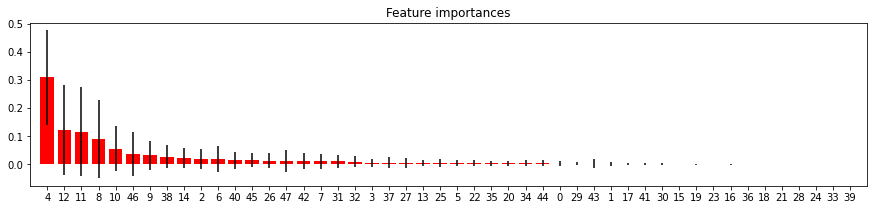

In [62]:
# Build a random forest and compute the feature importances
forest = RandomForestClassifier(max_depth=best_depth_rf_blncsmpl,bootstrap=True,criterion='gini',max_features='sqrt',random_state=50,n_estimators=250)
X = X_blncsmpl
y = y_blncsmpl

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15, 3))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [63]:
print(X_blncsmpl.columns[4])
print(X_blncsmpl.columns[12]) 
print(X_blncsmpl.columns[11]) 
print(X_blncsmpl.columns[8]) 
print(X_blncsmpl.columns[10]) 
print(X_blncsmpl.columns[46]) 
print(X_blncsmpl.columns[9]) 
print(X_blncsmpl.columns[38]) 
print(X_blncsmpl.columns[14]) 
print(X_blncsmpl.columns[2]) 
print(X_blncsmpl.columns[6]) 
print(X_blncsmpl.columns[40]) 
print(X_blncsmpl.columns[45]) 
print(X_blncsmpl.columns[26]) 
print(X_blncsmpl.columns[47]) 
print(X_blncsmpl.columns[42]) 
print(X_blncsmpl.columns[7]) 
print(X_blncsmpl.columns[31]) 
print(X_blncsmpl.columns[32])
print(X_blncsmpl.columns[3])
print(X_blncsmpl.columns[37])
print(X_blncsmpl.columns[27])
print(X_blncsmpl.columns[13])
print(X_blncsmpl.columns[25])
print(X_blncsmpl.columns[5])
print(X_blncsmpl.columns[22])
print(X_blncsmpl.columns[35])
print(X_blncsmpl.columns[20])
print(X_blncsmpl.columns[34])
print(X_blncsmpl.columns[44])

duration
nr.employed
euribor3m
emp.var.rate
cons.conf.idx
poutcome_nonexistent
cons.price.idx
default_unknown
job_blue-collar
month
pdays
housing_no
poutcome_failure
marital_married
poutcome_success
housing_yes
previous
education_basic.9y
education_high.school
day_of_week
default_no
marital_single
job_admin.
marital_divorced
campaign
job_technician
education_university.degree
job_services
education_professional.course
loan_yes


In [64]:
# Selecting the top 30 high_ranked features
selected_column_wrapper = X_blncsmpl[["duration","nr.employed","euribor3m","emp.var.rate","cons.conf.idx","poutcome_nonexistent","cons.price.idx","default_unknown","job_blue-collar","month","pdays","housing_no","poutcome_failure","marital_married","poutcome_success","housing_yes","previous","education_basic.9y","education_high.school","day_of_week","default_no","marital_single","job_admin.","marital_divorced","campaign","job_technician","education_university.degree","job_services","education_professional.course","loan_yes"]]


In [65]:
# Feature selection using wrapper - KNN model
start = time.time()
KNN_blncsmpl_wrapper_acc = sum(classifier_knn_fs(selected_column_wrapper, y_blncsmpl, best_k_blncdsmpl))/10
end = time.time()
KNN_blncsmpl_wrapper_runtime = "{:.2f}".format(end - start)
    
# Plotting cross validation accuracy of KNN
models = pd.DataFrame({
                    'number os selected features (wrapper method)': ['30','all(48)'],
                    '10-fold Cross Validation Accuracy on KNN model': [KNN_blncsmpl_wrapper_acc,sum(KNN_blncsmpl_acc)/10],
                    'Time to Train': [KNN_blncsmpl_wrapper_runtime,KNN_blncsmpl_runtime]
     
})
display(models.sort_values(by='10-fold Cross Validation Accuracy on KNN model', ascending=False))

,number os selected features (wrapper method),10-fold Cross Validation Accuracy on KNN model,Time to Train
1,all(48),0.950928,124.53
0,30,0.927896,88.23


In [66]:
# Feature selection using wrapper - SVM model
start = time.time()
SVM_blncsmpl_wrapper_acc = sum(classifier_svm_fs(selected_column_wrapper, y_blncsmpl))/10
end = time.time()
SVM_blncsmpl_wrapper_runtime = "{:.2f}".format(end - start)
    
# Plotting cross validation accuracy of SVM
models = pd.DataFrame({
                    'number os selected features (wrapper method)': ['30','all(48)'],
                    '10-fold Cross Validation Accuracy on SVM model': [SVM_blncsmpl_wrapper_acc,sum(SVM_blncsmpl_acc)/10],
                    'Time to Train': [SVM_blncsmpl_wrapper_runtime,SVM_blncsmpl_runtime]
})
display(models.sort_values(by='10-fold Cross Validation Accuracy on SVM model', ascending=False))

,number os selected features (wrapper method),10-fold Cross Validation Accuracy on SVM model,Time to Train
1,all(48),0.92288,909.45
0,30,0.91877,746.96
